In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
'''
Random forest analysis of metadata
Theo Portlock
'''
from scipy.spatial import distance
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor as RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skbio

sunjaemeta= pd.read_csv('../data/metadata_tables.tsv', index_col=0, sep='\t')
taxo = pd.read_csv('../../../../data/FMT/downstream_data/taxo.csv', index_col=0)
msp = pd.read_csv('../../../oldatlas/data/vect_atlas.csv', index_col=0)
meta = pd.read_csv('../../../oldatlas/data/unique_metadata.csv')
meta.host_phenotype = meta.host_phenotype.fillna('Healthy')
meta = meta.reset_index().set_index('sample_alias')
var = 'westernized'

newmeta = meta.join(sunjaemeta.set_index('metadata.ID')[var], how='inner')

msptaxo = msp.join(taxo['species']).groupby('species').sum().T
df = msptaxo.join(newmeta.set_index('secondary_sample_accession')[var], how='inner').dropna()

feature_imp = pd.DataFrame()
scorecurve = pd.DataFrame(columns=['scores', 'curves'])
scores = pd.Series()
curves = pd.Series()
testdf = df.copy()
classifier = RandomForestClassifier()
X = testdf.drop(var, axis=1)
y = testdf.xs(var, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
classifier.fit(X_train, y_train)


/var/folders/kh/8qkdf8v93m5gx3fn92grx7pw0000gn/T/ipykernel_1385/846848963.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series()
/var/folders/kh/8qkdf8v93m5gx3fn92grx7pw0000gn/T/ipykernel_1385/846848963.py:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  curves = pd.Series()


RandomForestRegressor()

In [9]:
meta

,index,sample_accession,study_accession,secondary_sample_accession,instrument_platform,instrument_model,library_layout,westernised,country,individual_id,...,gender,age,age_baby,bmi,HQ_clean_read_count,mapped_read_count,mapped_read_count_percentage,GC_10M,MGS_10M,depth_10M
sample_alias,,,,,,,,,,,,,,,,,,,,,
10219,0,SAMD00114718,PRJDB4176,DRS090823,ILLUMINA,Illumina HiSeq 2500,PAIRED,W,JPN,10219,...,male,68.0,NaN,21.383942,83422874,71887670,86.172613,384735,113,ok
10226,1,SAMD00114719,PRJDB4176,DRS090824,ILLUMINA,Illumina HiSeq 2500,PAIRED,W,JPN,10226,...,male,60.0,NaN,22.229062,46576580,39161257,84.079288,707817,286,ok
10229,2,SAMD00114720,PRJDB4176,DRS090825,ILLUMINA,Illumina HiSeq 2500,PAIRED,W,JPN,10229,...,male,66.0,NaN,24.609734,35816462,30376334,84.811096,451954,150,ok
10231,3,SAMD00114721,PRJDB4176,DRS090826,ILLUMINA,Illumina HiSeq 2500,PAIRED,W,JPN,10231,...,male,72.0,NaN,25.209201,62700060,53160178,84.784892,533936,195,ok
10232,4,SAMD00114722,PRJDB4176,DRS087519,ILLUMINA,Illumina HiSeq 2500,PAIRED,W,JPN,10232,...,male,64.0,NaN,22.460034,56699398,46527965,82.060774,726288,281,ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JN,5878,SAMN11355277,PRJNA531273,SRS4597872,ILLUMINA,NextSeq 500,PAIRED,NW,IND,JN,...,male,58.0,NaN,19.921875,9777268,7263639,74.291090,435610,198,NaN
JO,5879,SAMN11355278,PRJNA531273,SRS4597865,ILLUMINA,NextSeq 500,PAIRED,NW,IND,JO,...,male,71.0,NaN,20.028842,11265302,8932809,79.294892,616329,321,NaN
JP,5880,SAMN11355279,PRJNA531273,SRS4597866,ILLUMINA,NextSeq 500,PAIRED,NW,IND,JP,...,male,67.0,NaN,17.689789,10397840,7752031,74.554244,824867,477,NaN


In [2]:
import shap
explainer = shap.Explainer(classifier)
shap_values = explainer(X)

In [3]:
shap.initjs()
shap.plots.force(shap_values[0],text_rotation=15,  
                            show=False,  
                            feature_names=X.columns)

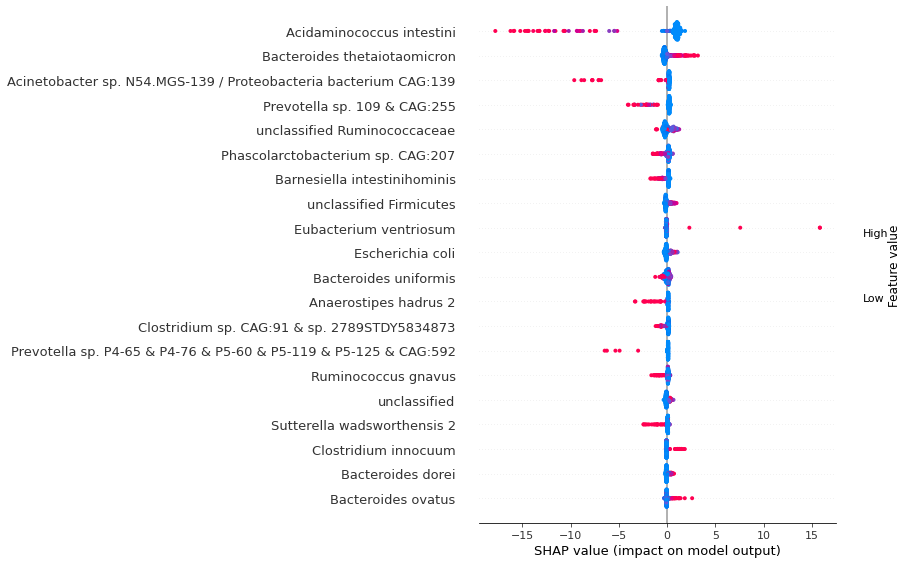

In [7]:
shap.summary_plot(shap_values)